##Clustering

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TFM/Dataset y archivos iniciales/datasetSeleccionadasPreClustering.csv', decimal='.')

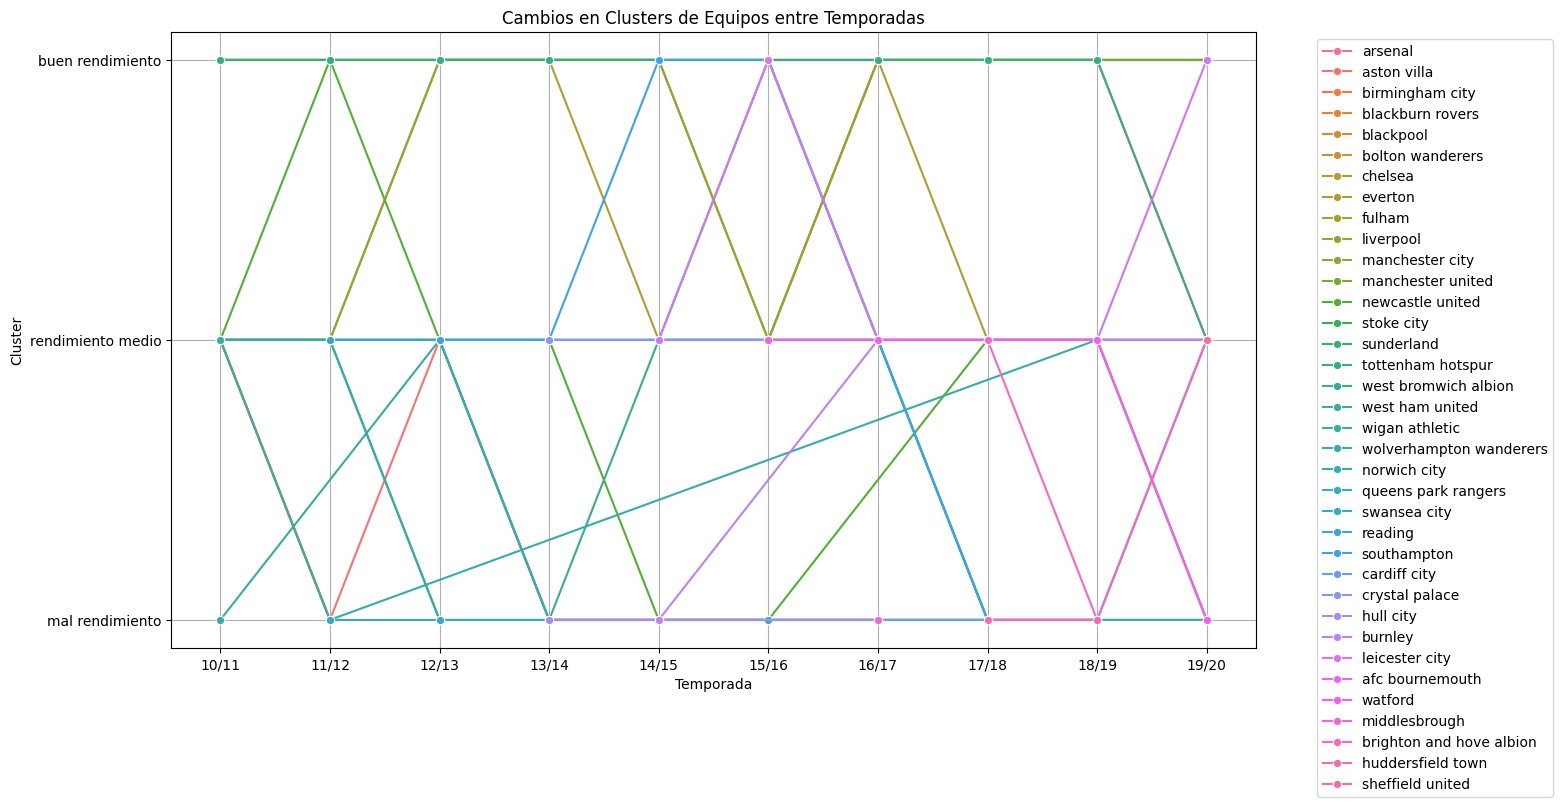

  season     team  points  goals_scored  goals_conceded           cluster  \
0  10/11  arsenal      68      0.592473        0.332374  buen rendimiento   
1  11/12  arsenal      70      0.618280        0.428777  buen rendimiento   
2  12/13  arsenal      73      0.596774        0.237410  buen rendimiento   
3  13/14  arsenal      79      0.544086        0.305036  buen rendimiento   
4  14/15  arsenal      75      0.580645        0.221583  buen rendimiento   

   previous_cluster  cluster_change  total_changes  
0               NaN           False              1  
1  buen rendimiento           False              1  
2  buen rendimiento           False              1  
3  buen rendimiento           False              1  
4  buen rendimiento           False              1  
                team  total_changes more_than_3  rendimiento_comun  \
26       southampton              5          SI  rendimiento medio   
16    leicester city              4          SI  rendimiento medio   
33   west

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Calcular victorias, empates y derrotas
df['home_win'] = np.where(df['goal_home_ft'] > df['goal_away_ft'], 1, 0)
df['away_win'] = np.where(df['goal_away_ft'] > df['goal_home_ft'], 1, 0)
df['draw'] = np.where(df['goal_home_ft'] == df['goal_away_ft'], 1, 0)

# Calcular puntos para cada equipo (3 puntos por victoria, 1 punto por empate, 0 por derrota)
df['home_points'] = df['home_win'] * 3 + df['draw']
df['away_points'] = df['away_win'] * 3 + df['draw']

# Descartar la temporada 20/21
df = df[df['season'] != '20/21']

df_home = df[['season', 'home_team', 'home_points', 'goal_home_ft', 'goal_away_ft']].rename(columns={
    'home_team': 'team',
    'home_points': 'points',
    'goal_home_ft': 'goals_scored',
    'goal_away_ft': 'goals_conceded'
})

df_away = df[['season', 'away_team', 'away_points', 'goal_away_ft', 'goal_home_ft']].rename(columns={
    'away_team': 'team',
    'away_points': 'points',
    'goal_away_ft': 'goals_scored',
    'goal_home_ft': 'goals_conceded'
})

# Concatenar los resultados de home y away
df_combined = pd.concat([df_home, df_away])

# Agrupar resultados por equipo y temporada
performance_metrics = df_combined.groupby(['season', 'team']).agg({
    'points': 'sum',
    'goals_scored': 'mean',
    'goals_conceded': 'mean'
}).reset_index()

# Normalizar goles anotados y goles encajados en el rango [0-1]
scaler = MinMaxScaler()
performance_metrics[['goals_scored', 'goals_conceded']] = scaler.fit_transform(performance_metrics[['goals_scored', 'goals_conceded']])

# Asignar clusters basados en puntos: <=40, 40-60, >=60
def assign_cluster(row):
    if row['points'] >= 60:
        return 'buen rendimiento'
    elif 40 <= row['points'] < 60:
        return 'rendimiento medio'
    else:
        return 'mal rendimiento'

performance_metrics['cluster'] = performance_metrics.apply(assign_cluster, axis=1)

# Analizar cambios de clusters entre temporadas (cambios de rendimiento)
performance_metrics['previous_cluster'] = performance_metrics.groupby('team')['cluster'].shift(1)
performance_metrics['cluster_change'] = (performance_metrics['cluster'] != performance_metrics['previous_cluster'])
performance_metrics.loc[performance_metrics['season'] == '10/11', 'cluster_change'] = False

# Contar cambios de cluster por equipo (cambios de rendimiento)
team_changes = performance_metrics.groupby('team')['cluster_change'].sum().reset_index().rename(columns={'cluster_change': 'total_changes'})
performance_metrics = performance_metrics.merge(team_changes, on='team')

# Columna más de 3 cambios
team_changes['more_than_3'] = team_changes['total_changes'].apply(lambda x: 'SI' if x > 3 else 'NO')

# Columna rendimiento_comun
def common_performance(team):
    clusters = performance_metrics[performance_metrics['team'] == team]['cluster']
    return clusters.mode().values[0]

team_changes['rendimiento_comun'] = team_changes['team'].apply(common_performance)

# Columna total de temporadas de cada equipo
team_seasons_count = performance_metrics[performance_metrics['season'] != '20/21'].groupby('team')['season'].nunique().reset_index().rename(columns={'season': 'total_seasons'})
team_changes = team_changes.merge(team_seasons_count, on='team')

team_changes = team_changes.sort_values(by='total_changes', ascending=False)

output_path_all_teams_sorted_with_seasons = '/content/drive/MyDrive/TFM/7. Comparativa entre temporadas/equipos_mas_de_3_cambios_sorted_with_seasons.csv'
team_changes.to_csv(output_path_all_teams_sorted_with_seasons, index=False)

# Visualizar de cambios de clusters entre temporadas
plt.figure(figsize=(14, 8))
sns.lineplot(data=performance_metrics, x='season', y='cluster', hue='team', marker='o')
plt.title('Cambios en Clusters de Equipos entre Temporadas')
plt.xlabel('Temporada')
plt.ylabel('Cluster')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

output_path = '/content/drive/MyDrive/TFM/7. Comparativa entre temporadas/resultados_clustering_temporadas.csv'
performance_metrics.to_csv(output_path, index=False)

print(performance_metrics.head())
print(team_changes.head())
